##Lecture Notebook:  Wrangling
In this lecture notebook, we will test the hypothesis that the CEOs of major companies are typically in their 40s or older, i.e. that they were born after 1980.  To do this, we will identify top companies, find their CEOs, extract their ages, and look at the distribution of ages.


In [0]:
# Let's start by installing some libraries that are useful for processing web data.

# For crawling pages
!pip3 install scrapy

# # Optional, for parallel execution
!pip3 install swifter

# # For string similarity
!pip3 install py_stringsimjoin

# # lxml to parse xml tree
!pip3 install lxml

     |████████████████████████████████| 235kB 8.9MB/s 
     |████████████████████████████████| 3.1MB 49.5MB/s 
     |████████████████████████████████| 61kB 27.5MB/s 
     |████████████████████████████████| 61kB 20.4MB/s 
     |████████████████████████████████| 174kB 40.1MB/s 
     |████████████████████████████████| 2.3MB 59.7MB/s 
  Created wheel for PyDispatcher: filename=PyDispatcher-2.0.5-cp36-none-any.whl size=11516 sha256=30682b1219343b84540e7577bb465294e0cb80e223ba2c3c277cf10827c451c7
  Stored in directory: /root/.cache/pip/wheels/88/99/96/cfef6665f9cb1522ee6757ae5955feedf2fe25f1737f91fa7f
Successfully built PyDispatcher
     |████████████████████████████████| 61kB 7.7MB/s 
  Created wheel for swifter: filename=swifter-0.295-cp36-none-any.whl size=6641 sha256=816919e40913486ed34323443e5a2ea6b5b1dcbecfc8dae6a5eb6f72e254afee
  Stored in directory: /root/.cache/pip/wheels/7a/45/c9/3f3efdf849089406d6601314016dd99f8b15480944e3bf8dad
  Created wheel for locket: filename=locket-0.2.0-cp

     |████████████████████████████████| 1.1MB 9.7MB/s 
     |████████████████████████████████| 655kB 43.5MB/s 
  Created wheel for py-stringsimjoin: filename=py_stringsimjoin-0.3.1-cp36-cp36m-linux_x86_64.whl size=3749360 sha256=1788d47876a8fde0ec02cdbeac487fc254f32628641d3005801aa8752ae37932
  Stored in directory: /root/.cache/pip/wheels/c5/e2/5c/6baab160a69a851b8784f6a18754719463700cdb7b6526e544
  Created wheel for py-stringmatching: filename=py_stringmatching-0.4.1-cp36-cp36m-linux_x86_64.whl size=2055292 sha256=0de4c41bf96b083e412bbd157aab7787fac248990ea6944e39820e045281d3d1
  Stored in directory: /root/.cache/pip/wheels/60/7a/90/37ae79d15afb482c2fa1a58a45fadd1945ed1d09fc8d50d4b6
Successfully built py-stringsimjoin py-stringmatching


In [0]:
# Here are some imports we'll use through the notebook, collected here for simplicity

# For parsing dates and being able to compare
import datetime

# For fetching remote data
import urllib

# Pandas dataframes and operations
import pandas as pd

# Numpy matrix and array operations
import numpy as np

# Sqlite is a simplistic database
import sqlite3

# Crawler for multiple web pages at once
import scrapy
from scrapy.crawler import CrawlerProcess

# Can use dataframe.swifter.apply() instead of dataframe.apply()
# to try to parallelize the computation!
import swifter

# Approximate string matching, see 
import py_stringsimjoin as ssj
import py_stringmatching as sm

# Data visualization
import matplotlib

# import urllib and etree for download and parsing
from lxml import etree

## 1. Acquiring data about companies and CEOs.

We'll start by loading a (remote) CSV file containing information about companies into a dataframe (company_data_df), and then persist it to an SQLite database.  We'll also read an HTML file to obtain information about the CEOs of companies, and put in another dataframe (company_ceos_df).

In [0]:
data = urllib.request.urlopen(\
       'https://gist.githubusercontent.com/jvilledieu/c3afe5bc21da28880a30/raw/a344034b82a11433ba6f149afa47e57567d4a18f/Companies.csv')

company_data_df = pd.read_csv(data)
    

In [0]:
# Persist it to an SQLite database, and read it back.

conn = sqlite3.connect('local.db')

company_data_df.to_sql("companies", conn, if_exists="replace", index=False)

pd.read_sql_query('select * from companies', conn)

,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,1 750 000,acquired,USA,NY,New York City,New York,1,01/06/2012,2012-06,2012-Q2,2012.0,30/06/2012,30/06/2012
1,/organization/tv-communications,&TV Communications,http://enjoyandtv.com,|Games|,Games,4 000 000,operating,USA,CA,Los Angeles,Los Angeles,2,None,None,None,NaN,04/06/2010,23/09/2010
2,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,40 000,operating,EST,None,Tallinn,Tallinn,1,26/10/2012,2012-10,2012-Q4,2012.0,09/08/2012,09/08/2012
3,/organization/in-touch-network,(In)Touch Network,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|iPhone|Apps|Mobile|iOS|E-Commerce|,Electronics,1 500 000,operating,GBR,None,London,London,1,01/04/2011,2011-04,2011-Q2,2011.0,01/04/2011,01/04/2011
4,/organization/n-plusn,+n (PlusN),http://plusn.com,|Software|,Software,1 200 000,operating,USA,NY,New York City,New York,2,01/01/2012,2012-01,2012-Q1,2012.0,29/08/2012,04/09/2014
5,/organization/r-ranch-and-mine,-R- Ranch and Mine,None,|Entertainment|Games|,Games,10 000,operating,USA,TX,Dallas,Fort Worth,1,08/07/2014,2014-07,2014-Q3,2014.0,17/08/2014,17/08/2014
6,/organization/club-domains,.Club Domains,http://nic.club/,|Software|,Software,7 000 000,None,USA,FL,Ft. Lauderdale,Oakland Park,1,10/10/2011,2011-10,2011-Q4,2011.0,31/05/2013,31/05/2013
7,/organization/fox-networks,.Fox Networks,http://www.dotfox.com,|Advertising|,Advertising,4 912 393,closed,ARG,None,Buenos Aires,Buenos Aires,1,None,None,None,NaN,16/01/2007,16/01/2007
8,/organization/0-6-com,0-6.com,http://www.0-6.com,|Curated Web|,Curated Web,2 000 000,operating,None,None,None,None,1,01/01/2007,2007-01,2007-Q1,2007.0,19/03/2008,19/03/2008
9,/organization/004-technologies,004 Technologies,http://004gmbh.de/en/004-interact,|Software|,Software,-,operating,USA,IL,"Springfield, Illinois",Champaign,1,01/01/2010,2010-01,2010-Q1,2010.0,24/07/2014,24/07/2014


In [0]:
# Now let's read an HTML table containing information about CEOs!

company_ceos_df = pd.read_html('https://en.wikipedia.org/wiki/List_of_chief_executive_officers#List_of_CEOs')[0]

company_ceos_df

,Company,Executive,Title,Since,Notes,Updated
0,Accenture,Julie Sweet,Interim CEO[1],2019,"Succeeded Pierre Nanterme, Passed Away",2019-01-31
1,Aditya Birla Group,Kumar Birla,Chairman[2],1995[2],Part of the Birla family business house in India,2018-10-01
2,Adobe Systems,Shantanu Narayen,"Chairman, president and CEO[3]",2007,Formerly with Apple Inc.,2018-10-01
3,Agenus,Garo H. Armen,"Founder, chairman, CEO[4]",1994,Founder of the Children of Armenia Fund (COAF),2018-10-01
4,Airbus,Tom Enders,CEO[5],2012,Succeeded Louis Gallois,2017-11-14
5,Alibaba,Daniel Zhang,CEO[6],2015,Previously with Taobao,2018-10-01
6,Amazon.com,Jeff Bezos,"President, CEO and chairman[7]",1994,Founder of the firm and one of the world's wealthiest people,2018-10-01
7,AMD,Lisa Su,CEO and president[8],2014,Formerly with Texas Instruments,2018-10-01
8,American Express,Stephen Squeri,Chairman and CEO[9],2018,Former vice chairman of American Express since 2015,2018-10-01
9,American Airlines Group,Doug Parker,Chairman and CEO[10],2013,Previously CEO for US Airways,2018-10-01


## 2. The Problem Gets Harder: Extracting Structured Data

Ultimately, we need to find the date of birth of the CEOs.  We'll do this by crawling and scraping data from Wikipedia.

###Create a list of CEO web pages to be crawled by appending the Executive (name) onto the Wikipedia http address.

In [0]:
crawl_list = []

for executive in company_ceos_df['Executive']:
  crawl_list.append('https://en.wikipedia.org/wiki/' + executive.replace(' ', '_'))
 
crawl_list

['https://en.wikipedia.org/wiki/Julie_Sweet',
 'https://en.wikipedia.org/wiki/Kumar_Birla',
 'https://en.wikipedia.org/wiki/Shantanu_Narayen',
 'https://en.wikipedia.org/wiki/Garo_H._Armen',
 'https://en.wikipedia.org/wiki/Tom_Enders',
 'https://en.wikipedia.org/wiki/Daniel_Zhang',
 'https://en.wikipedia.org/wiki/Jeff_Bezos',
 'https://en.wikipedia.org/wiki/Lisa_Su',
 'https://en.wikipedia.org/wiki/Stephen_Squeri',
 'https://en.wikipedia.org/wiki/Doug_Parker',
 'https://en.wikipedia.org/wiki/Joseph_R._Swedish',
 'https://en.wikipedia.org/wiki/Tim_Cook',
 'https://en.wikipedia.org/wiki/Lakshmi_Niwas_Mittal',
 'https://en.wikipedia.org/wiki/Randall_L._Stephenson',
 'https://en.wikipedia.org/wiki/Charles_Woodburn',
 'https://en.wikipedia.org/wiki/Tapan_Singhel',
 'https://en.wikipedia.org/wiki/Carlos_Torres_Vila',
 'https://en.wikipedia.org/wiki/Brian_Moynihan',
 'https://en.wikipedia.org/wiki/Jes_Staley',
 'https://en.wikipedia.org/wiki/Warren_Buffett',
 'https://en.wikipedia.org/wiki/Hu

### Crawl each web page in crawl_list to obtain HTML content, and store in a list called pages.




In [0]:
# Use urllib to crawl all pages in crawl_list, and store the response of the page
# in list pages 

pages = []

for url in crawl_list:
    page = url.split("/")[-1] #extract the person name at the end of the url
    print('Looking at file %s' % page)
    # Split the url into different parts, and convert the person name into ascii code
    url_list = list(urllib.parse.urlsplit(url))
    url_list[2] = urllib.parse.quote(url_list[2])
    url_ascii = urllib.parse.urlunsplit(url_list)
    try:
      response = urllib.request.urlopen((url_ascii))
      #Save page and ulr for later use.
      pages.append(response)
    except urllib.error.URLError as e:
      print(e.reason)


Looking at file Julie_Sweet
Looking at file Kumar_Birla
Looking at file Shantanu_Narayen
Looking at file Garo_H._Armen
Looking at file Tom_Enders
Looking at file Daniel_Zhang
Looking at file Jeff_Bezos
Looking at file Lisa_Su
Looking at file Stephen_Squeri
Looking at file Doug_Parker
Looking at file Joseph_R._Swedish
Looking at file Tim_Cook
Looking at file Lakshmi_Niwas_Mittal
Looking at file Randall_L._Stephenson
Looking at file Charles_Woodburn
Looking at file Tapan_Singhel
Looking at file Carlos_Torres_Vila
Looking at file Brian_Moynihan
Looking at file Jes_Staley
Looking at file Warren_Buffett
Looking at file Hubert_Joly
Looking at file Sunil_Bharti_Mittal
Looking at file Stephen_A._Schwarzman
Looking at file Andrew_Mackenzie
Looking at file Harald_Krüger
Looking at file Charles_Scharf
Looking at file Dennis_Muilenburg
Looking at file Rich_Lesser
Looking at file Bob_Dudley
Looking at file Denise_Morrison
Looking at file Mark_Shuttleworth
Looking at file Paul_Hermelin
Looking at fi

In [0]:
pages

### Populate a table with the name, web page URL,  and birth date of each CEO.  

In [0]:
# Use etree.HTML(...) on the HTML content of each page to get a DOM tree that
# can be processed via XPath to extract the bday information.  Store the CEO name, 
# webpage, and the birthdate (born) in exec_df.

# We first check that the HTML content has a table of type vcard,
# and then extract the bday information.  If there is no birthdate, the datetime 
# value is NaT (not a type). 


exec_df = pd.DataFrame(columns=['name','page','born'])

for page in pages:  
  
    tree = etree.HTML(page.read().decode("utf-8"))  #create a DOM tree of the page
    url = page.geturl()
    bday = tree.xpath('//table[contains(@class,"vcard")]//tbody/tr/td//span[@class="bday"]/text()')
    if (len(bday)>0):
        exec_df = exec_df.append({'name': url[url.rfind('/')+1:], 'page': url,
                   'born': datetime.datetime.strptime(bday[0], '%Y-%m-%d')}, ignore_index=True)
    else: 
            exec_df = exec_df.append({'name': url[url.rfind('/')+1:], 'page': url
                                      , 'born': None}, ignore_index=True)
        
exec_df

,name,page,born
0,Julie_Sweet,https://en.wikipedia.org/wiki/Julie_Sweet,NaT
1,Kumar_Birla,https://en.wikipedia.org/wiki/Kumar_Birla,1967-06-14
2,Shantanu_Narayen,https://en.wikipedia.org/wiki/Shantanu_Narayen,1963-05-27
3,Garo_H._Armen,https://en.wikipedia.org/wiki/Garo_H._Armen,1953-01-31
4,Tom_Enders,https://en.wikipedia.org/wiki/Tom_Enders,NaT
5,Daniel_Zhang,https://en.wikipedia.org/wiki/Daniel_Zhang,1972-01-11
6,Jeff_Bezos,https://en.wikipedia.org/wiki/Jeff_Bezos,1964-01-12
7,Lisa_Su,https://en.wikipedia.org/wiki/Lisa_Su,1969-11-07
8,Stephen_Squeri,https://en.wikipedia.org/wiki/Stephen_Squeri,NaT
9,Doug_Parker,https://en.wikipedia.org/wiki/Doug_Parker,NaT


## 3. Cleaning and manipulating the tables

We eventually want to join exec_df with company_ceos_df.  However, looking at exec_df we notice that the name in exec_df has underscores, which will not match the names of executives in company_ceos_df.  We will therefore need to clean the name field in exec_df. 


In [0]:
# Let's take a look at the name and born data in exec_df.  We do this via projection.  
# Notice also (e.g. row 24) that special characters will cause issues.


exec_df[['name', 'born']]

,name,born
0,Julie_Sweet,NaT
1,Kumar_Birla,1967-06-14
2,Shantanu_Narayen,1963-05-27
3,Garo_H._Armen,1953-01-31
4,Tom_Enders,NaT
5,Daniel_Zhang,1972-01-11
6,Jeff_Bezos,1964-01-12
7,Lisa_Su,1969-11-07
8,Stephen_Squeri,NaT
9,Doug_Parker,NaT


In [0]:
# Clean the name by removing underscores, and store in a new field called clean_name.

exec_df['clean_name'] = exec_df['name'].apply(lambda x: x.replace('_', ' '))

exec_df

,name,page,born,clean_name
0,Julie_Sweet,https://en.wikipedia.org/wiki/Julie_Sweet,NaT,Julie Sweet
1,Kumar_Birla,https://en.wikipedia.org/wiki/Kumar_Birla,1967-06-14,Kumar Birla
2,Shantanu_Narayen,https://en.wikipedia.org/wiki/Shantanu_Narayen,1963-05-27,Shantanu Narayen
3,Garo_H._Armen,https://en.wikipedia.org/wiki/Garo_H._Armen,1953-01-31,Garo H. Armen
4,Tom_Enders,https://en.wikipedia.org/wiki/Tom_Enders,NaT,Tom Enders
5,Daniel_Zhang,https://en.wikipedia.org/wiki/Daniel_Zhang,1972-01-11,Daniel Zhang
6,Jeff_Bezos,https://en.wikipedia.org/wiki/Jeff_Bezos,1964-01-12,Jeff Bezos
7,Lisa_Su,https://en.wikipedia.org/wiki/Lisa_Su,1969-11-07,Lisa Su
8,Stephen_Squeri,https://en.wikipedia.org/wiki/Stephen_Squeri,NaT,Stephen Squeri
9,Doug_Parker,https://en.wikipedia.org/wiki/Doug_Parker,NaT,Doug Parker


In [0]:
# We can do the same via SQL.  For the example we'll save the dataframe first, and then extract just the name and clean_name using SQL.

exec_df.to_sql('temp_exec', conn, if_exists="replace")

pd.read_sql_query('select name, replace(name, "_", " ") as clean_name from temp_exec', conn)

,name,clean_name
0,Julie_Sweet,Julie Sweet
1,Kumar_Birla,Kumar Birla
2,Shantanu_Narayen,Shantanu Narayen
3,Garo_H._Armen,Garo H. Armen
4,Tom_Enders,Tom Enders
5,Daniel_Zhang,Daniel Zhang
6,Jeff_Bezos,Jeff Bezos
7,Lisa_Su,Lisa Su
8,Stephen_Squeri,Stephen Squeri
9,Doug_Parker,Doug Parker


In [0]:
exec_df['clean_name']

0                Julie Sweet
1                Kumar Birla
2           Shantanu Narayen
3              Garo H. Armen
4                 Tom Enders
5               Daniel Zhang
6                 Jeff Bezos
7                    Lisa Su
8             Stephen Squeri
9                Doug Parker
10         Joseph R. Swedish
11                  Tim Cook
12      Lakshmi Niwas Mittal
13     Randall L. Stephenson
14          Charles Woodburn
15             Tapan Singhel
16        Carlos Torres Vila
17            Brian Moynihan
18                Jes Staley
19            Warren Buffett
20               Hubert Joly
21       Sunil Bharti Mittal
22     Stephen A. Schwarzman
23          Andrew Mackenzie
24        Harald Kr%C3%BCger
25            Charles Scharf
26         Dennis Muilenburg
27               Rich Lesser
28                Bob Dudley
29           Denise Morrison
               ...          
152             Li Dongsheng
153                Andy Penn
154                 Ho Ching
155           

In [0]:
exec_df['clean_name']=='Kumar Birla'

0      False
1       True
2      False
3      False
4      False
5      False
6      False
7      False
8      False
9      False
10     False
11     False
12     False
13     False
14     False
15     False
16     False
17     False
18     False
19     False
20     False
21     False
22     False
23     False
24     False
25     False
26     False
27     False
28     False
29     False
       ...  
152    False
153    False
154    False
155    False
156    False
157    False
158    False
159    False
160    False
161    False
162    False
163    False
164    False
165    False
166    False
167    False
168    False
169    False
170    False
171    False
172    False
173    False
174    False
175    False
176    False
177    False
178    False
179    False
180    False
181    False
Name: clean_name, Length: 182, dtype: bool

In [0]:
exec_df[exec_df['clean_name']=='Kumar Birla']

,name,page,born,clean_name
1,Kumar_Birla,https://en.wikipedia.org/wiki/Kumar_Birla,1967-06-14,Kumar Birla


In [0]:
exec_df.to_sql('temp_exec', conn, if_exists="replace")
pd.read_sql_query('select * from temp_exec where clean_name="Kumar Birla"', conn)

,index,name,page,born,clean_name
0,1,Kumar_Birla,https://en.wikipedia.org/wiki/Kumar_Birla,1967-06-14 00:00:00,Kumar Birla


## 4.  Putting it together: 

Now join exec_df with company_ceos_df to get company information.

### Joining Data

We start with a simple join between company_ceos_df and exec_df and persist it to the database.  We then check how many companies did not have a match on CEO name.

In [0]:
company_ceos_df[['Executive', 'Company']].merge(exec_df[['clean_name', 'born']], 
                                                left_on=['Executive'], 
                                                right_on=['clean_name'])

,Executive,Company,clean_name,born
0,Julie Sweet,Accenture,Julie Sweet,NaT
1,Kumar Birla,Aditya Birla Group,Kumar Birla,1967-06-14
2,Shantanu Narayen,Adobe Systems,Shantanu Narayen,1963-05-27
3,Garo H. Armen,Agenus,Garo H. Armen,1953-01-31
4,Tom Enders,Airbus,Tom Enders,NaT
5,Daniel Zhang,Alibaba,Daniel Zhang,1972-01-11
6,Jeff Bezos,Amazon.com,Jeff Bezos,1964-01-12
7,Lisa Su,AMD,Lisa Su,1969-11-07
8,Stephen Squeri,American Express,Stephen Squeri,NaT
9,Doug Parker,American Airlines Group,Doug Parker,NaT


In [0]:
merged_df = company_ceos_df[['Executive', 'Company']].merge(exec_df[['clean_name', 'born']], 
                                                left_on=['Executive'], 
                                                right_on=['clean_name'])
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
  print(merged_df['clean_name'])

0                         Julie Sweet
1                         Kumar Birla
2                    Shantanu Narayen
3                       Garo H. Armen
4                          Tom Enders
5                        Daniel Zhang
6                          Jeff Bezos
7                             Lisa Su
8                      Stephen Squeri
9                         Doug Parker
10                  Joseph R. Swedish
11                           Tim Cook
12               Lakshmi Niwas Mittal
13              Randall L. Stephenson
14                   Charles Woodburn
15                      Tapan Singhel
16                 Carlos Torres Vila
17                     Brian Moynihan
18                         Jes Staley
19                     Warren Buffett
20                        Hubert Joly
21                Sunil Bharti Mittal
22              Stephen A. Schwarzman
23                   Andrew Mackenzie
24                     Charles Scharf
25                  Dennis Muilenburg
26          

In [0]:
company_ceos_df.to_sql('company_ceos', conn, if_exists="replace")
exec_df.to_sql('executives', conn, if_exists="replace")

pd.read_sql_query('select Executive, Company, born from company_ceos ' +\
                  'join executives on Executive=clean_name', conn)

,Executive,Company,born
0,Julie Sweet,Accenture,None
1,Kumar Birla,Aditya Birla Group,1967-06-14 00:00:00
2,Shantanu Narayen,Adobe Systems,1963-05-27 00:00:00
3,Garo H. Armen,Agenus,1953-01-31 00:00:00
4,Tom Enders,Airbus,None
5,Daniel Zhang,Alibaba,1972-01-11 00:00:00
6,Jeff Bezos,Amazon.com,1964-01-12 00:00:00
7,Lisa Su,AMD,1969-11-07 00:00:00
8,Stephen Squeri,American Express,None
9,Doug Parker,American Airlines Group,None


###Finding the misses in the join.

Note that the join above resulted in 177 rows.  However, there are more rows in company_ceos_df so we are missing some companies.  We can see which are missed using a left outer join; setting "indicator= True" allows us to see which tuples in company_ceos_df failed to find a match (left_only, e.g. row 24 and 172).

In [0]:
company_ceos_df[['Executive', 'Company']].merge(exec_df[['clean_name', 'born']], 
                                                left_on=['Executive'], 
                                                right_on=['clean_name'], how="left", indicator=True)



,Executive,Company,clean_name,born,_merge
0,Julie Sweet,Accenture,Julie Sweet,NaT,both
1,Kumar Birla,Aditya Birla Group,Kumar Birla,1967-06-14,both
2,Shantanu Narayen,Adobe Systems,Shantanu Narayen,1963-05-27,both
3,Garo H. Armen,Agenus,Garo H. Armen,1953-01-31,both
4,Tom Enders,Airbus,Tom Enders,NaT,both
5,Daniel Zhang,Alibaba,Daniel Zhang,1972-01-11,both
6,Jeff Bezos,Amazon.com,Jeff Bezos,1964-01-12,both
7,Lisa Su,AMD,Lisa Su,1969-11-07,both
8,Stephen Squeri,American Express,Stephen Squeri,NaT,both
9,Doug Parker,American Airlines Group,Doug Parker,NaT,both


## 5. Cleaning the Data, Revisited

When we looked at the names of CEOs in exec_df, we noticed that special characters in the name were garbled.  We'll take a closer look at these garbled names, and then determine how to find matches without cleaning them using approximate matching ("similarity").

In [0]:
# Find names with invalid chacters using with validation rules

replace_char = 'Q'

failed = False
for name in exec_df['clean_name']:
  if not name.replace(' ', replace_char).\
          replace('.', replace_char).\
          replace('\'',replace_char).\
          replace('-',replace_char).isalpha():
    print ("Illegal name %s"%name)
    failed = True
    
if failed:
  raise AssertionError('Found illegal names!')

Illegal name Harald Kr%C3%BCger
Illegal name Francisco D%27Souza
Illegal name B%C3%B6rje Ekholm
Illegal name Michael O%27Leary
Illegal name Matthias M%C3%BCller


AssertionError: ignored

### Working around the Errors

Rather than figuring out how to clean these characters, we'll use approximate matching.  We'll first import some similarity matching code, to do approximate match between the original names and those returned by Wikipedia.

In [0]:
# We are going to match the strings approximately, via "n-grams" or "q-grams" (sequences of n or q characters)
# Here we use five-grams.

tok = sm.QgramTokenizer(qval=5,return_set=True)

In [0]:
# Now let's do a similarity join

# We'll reset the index, so there is a unique index field in the company_ceos_df dataframe. 
#Noice that we are able to match 183 companies -- better than 180 using exact match, but still missing one company.

company_ceos_df.reset_index(inplace=True)

output_pairs = ssj.jaccard_join(company_ceos_df, exec_df, 'index', 'page', 'Executive', 'clean_name', tok, 0.35, 
                                l_out_attrs=['Executive'], r_out_attrs=['clean_name'])

output_pairs

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


,_id,l_index,r_page,l_Executive,r_clean_name,_sim_score
0,0,0,https://en.wikipedia.org/wiki/Julie_Sweet,Julie Sweet,Julie Sweet,1.000000
1,1,1,https://en.wikipedia.org/wiki/Kumar_Birla,Kumar Birla,Kumar Birla,1.000000
2,2,2,https://en.wikipedia.org/wiki/Shantanu_Narayen,Shantanu Narayen,Shantanu Narayen,1.000000
3,3,3,https://en.wikipedia.org/wiki/Garo_H._Armen,Garo H. Armen,Garo H. Armen,1.000000
4,4,4,https://en.wikipedia.org/wiki/Tom_Enders,Tom Enders,Tom Enders,1.000000
5,5,5,https://en.wikipedia.org/wiki/Daniel_Zhang,Daniel Zhang,Daniel Zhang,1.000000
6,6,6,https://en.wikipedia.org/wiki/Jeff_Bezos,Jeff Bezos,Jeff Bezos,1.000000
7,7,7,https://en.wikipedia.org/wiki/Lisa_Su,Lisa Su,Lisa Su,1.000000
8,8,8,https://en.wikipedia.org/wiki/Stephen_Squeri,Stephen Squeri,Stephen Squeri,1.000000
9,9,9,https://en.wikipedia.org/wiki/Doug_Parker,Doug Parker,Doug Parker,1.000000


In [0]:
# At last! Company info + CEO info, together!

total = company_ceos_df.merge(output_pairs,left_on=['Executive'],right_on=['l_Executive']).\
        merge(exec_df,left_on=['r_page'],right_on=['page'])

total

,level_0,index,Company,Executive,Title,Since,Notes,Updated,_id,l_index,r_page,l_Executive,r_clean_name,_sim_score,name,page,born,clean_name,born_decade
0,0,0,Accenture,Julie Sweet,Interim CEO[1],2019,"Succeeded Pierre Nanterme, Passed Away",2019-01-31,0,0,https://en.wikipedia.org/wiki/Julie_Sweet,Julie Sweet,Julie Sweet,1.000000,Julie_Sweet,https://en.wikipedia.org/wiki/Julie_Sweet,NaT,Julie Sweet,NaN
1,1,1,Aditya Birla Group,Kumar Birla,Chairman[2],1995[2],Part of the Birla family business house in India,2018-10-01,1,1,https://en.wikipedia.org/wiki/Kumar_Birla,Kumar Birla,Kumar Birla,1.000000,Kumar_Birla,https://en.wikipedia.org/wiki/Kumar_Birla,1967-06-14,Kumar Birla,1960s
2,2,2,Adobe Systems,Shantanu Narayen,"Chairman, president and CEO[3]",2007,Formerly with Apple Inc.,2018-10-01,2,2,https://en.wikipedia.org/wiki/Shantanu_Narayen,Shantanu Narayen,Shantanu Narayen,1.000000,Shantanu_Narayen,https://en.wikipedia.org/wiki/Shantanu_Narayen,1963-05-27,Shantanu Narayen,1960s
3,3,3,Agenus,Garo H. Armen,"Founder, chairman, CEO[4]",1994,Founder of the Children of Armenia Fund (COAF),2018-10-01,3,3,https://en.wikipedia.org/wiki/Garo_H._Armen,Garo H. Armen,Garo H. Armen,1.000000,Garo_H._Armen,https://en.wikipedia.org/wiki/Garo_H._Armen,1953-01-31,Garo H. Armen,1950s
4,4,4,Airbus,Tom Enders,CEO[5],2012,Succeeded Louis Gallois,2017-11-14,4,4,https://en.wikipedia.org/wiki/Tom_Enders,Tom Enders,Tom Enders,1.000000,Tom_Enders,https://en.wikipedia.org/wiki/Tom_Enders,NaT,Tom Enders,NaN
5,5,5,Alibaba,Daniel Zhang,CEO[6],2015,Previously with Taobao,2018-10-01,5,5,https://en.wikipedia.org/wiki/Daniel_Zhang,Daniel Zhang,Daniel Zhang,1.000000,Daniel_Zhang,https://en.wikipedia.org/wiki/Daniel_Zhang,1972-01-11,Daniel Zhang,1970s
6,6,6,Amazon.com,Jeff Bezos,"President, CEO and chairman[7]",1994,Founder of the firm and one of the world's wealthiest people,2018-10-01,6,6,https://en.wikipedia.org/wiki/Jeff_Bezos,Jeff Bezos,Jeff Bezos,1.000000,Jeff_Bezos,https://en.wikipedia.org/wiki/Jeff_Bezos,1964-01-12,Jeff Bezos,1960s
7,7,7,AMD,Lisa Su,CEO and president[8],2014,Formerly with Texas Instruments,2018-10-01,7,7,https://en.wikipedia.org/wiki/Lisa_Su,Lisa Su,Lisa Su,1.000000,Lisa_Su,https://en.wikipedia.org/wiki/Lisa_Su,1969-11-07,Lisa Su,1960s
8,8,8,American Express,Stephen Squeri,Chairman and CEO[9],2018,Former vice chairman of American Express since 2015,2018-10-01,8,8,https://en.wikipedia.org/wiki/Stephen_Squeri,Stephen Squeri,Stephen Squeri,1.000000,Stephen_Squeri,https://en.wikipedia.org/wiki/Stephen_Squeri,NaT,Stephen Squeri,NaN
9,9,9,American Airlines Group,Doug Parker,Chairman and CEO[10],2013,Previously CEO for US Airways,2018-10-01,9,9,https://en.wikipedia.org/wiki/Doug_Parker,Doug Parker,Doug Parker,1.000000,Doug_Parker,https://en.wikipedia.org/wiki/Doug_Parker,NaT,Doug Parker,NaN


##6. Visualizing the result.

To understand the distribution of birth dates, we want to count the number of CEOs born on each date/year/decade represented.  We will then plot a histogram of the result, take a look, and see if our hypothesis that most CEOs are 40 years old or older (born after 1980) is correct!

In [0]:
# Let's get ready to plot

%matplotlib inline

### Grouping

The `groupby` command allows us to coalesce data by groups.  In Pandas a Group is a special object with a set of rows.  We can see this with the `get_group` command.

In [0]:
total.groupby(by='born').get_group(datetime.datetime.strptime('1945-08-24', '%Y-%m-%d'))

,level_0,index,Company,Executive,Title,Since,Notes,Updated,_id,l_index,r_page,l_Executive,r_clean_name,_sim_score,name,page,born,clean_name,born_decade
179,182,182,WWE,Vince McMahon,Chairman and CEO[170],2009,Chairman of the executive committeeChairman since 1980President and CEO from 1980-1993,2017-11-11,179,182,https://en.wikipedia.org/wiki/Vince_McMahon,Vince McMahon,Vince McMahon,1.0,Vince_McMahon,https://en.wikipedia.org/wiki/Vince_McMahon,1945-08-24,Vince McMahon,1940s


In [0]:
# Let's take a look at when people are born by sorting the data by born. 
# It turns out that very few people share the same birthdate! 

total[['born','Company','Executive']].sort_values('born')

,born,Company,Executive
103,1923-05-27,National Amusements,Sumner Redstone
72,1929-03-07,Henderson Land Development,Lee Shau Kee
19,1930-08-30,Berkshire Hathaway,Warren Buffett
88,1933-08-04,Las Vegas Sands,Sheldon Adelson
86,1935-11-01,Koch Industries Inc.,Charles G. Koch
70,1937-03-22,GVK Group,Gunupati Venkata Krishna Reddy
89,1937-09-08,L Brands,Les Wexner
69,1939-12-08,GMA Network,Felipe Gozon
42,1940-01-14,Crown Worldwide Group,James E. Thompson
172,1941-06-04,Walgreens Boots Alliance,Stefano Pessina


###Counting
Rather than just eyeballing adjacent rows, we can apply computations, such as `count`, to groups of CEOs with the same born date.  Values that are empty (NaT) do not count (no pun intended), so there are only 98 rows in the result.

In [0]:
# Count how many CEOs are born on each born date by using groupby on 'born' and using count().
# Seems that most (all?) of the born dates are unique!

birthdays = total.groupby(by='born').count()[['Executive']]

birthdays

,Executive
born,
1923-05-27,1
1929-03-07,1
1930-08-30,1
1933-08-04,1
1935-11-01,1
1937-03-22,1
1937-09-08,1
1939-12-08,1
1940-01-14,1


In [0]:
# We can do this in SQL too...

total.to_sql('total_info', conn, if_exists='replace', index=False)

# By default, SQL will include the NaT value (called NULL in SQL).  If we want to exclude it, 
# we need to include WHERE ... IS NOT NULL.

pd.read_sql('select born, count(Company) from total_info ' +\
            'where born is not null group by born', conn)

,born,count(Company)
0,1923-05-27 00:00:00,1
1,1929-03-07 00:00:00,1
2,1930-08-30 00:00:00,1
3,1933-08-04 00:00:00,1
4,1935-11-01 00:00:00,1
5,1937-03-22 00:00:00,1
6,1937-09-08 00:00:00,1
7,1939-12-08 00:00:00,1
8,1940-01-14 00:00:00,1
9,1941-06-04 00:00:00,1


###Group by decade.

To get a better sense of how birthdates cluster, we will first calculate the decade in which each CEO is born, group them by decade and plot by decade using a bar chart. 

In [0]:
# Add a decade column to 'exec_df' and populate it.

bdays = total[['born']].dropna()

bdays = bdays.applymap(lambda bday: str(int(bday.year / 10) * 10) + 's')

exec_df[['born_decade']] = bdays

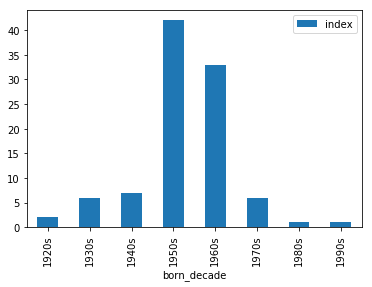

In [0]:
# Plot the result.

exec_df[['born_decade']].reset_index().groupby('born_decade').count().plot(kind='bar')

### So are most CEO's born before 1980s?

## 7.  An Exercise

Take this one step further, and link the companies table with another dataset to determine the market for each company.

Is there a correlation between the kind of company and the age of the CEO?